In [1]:
import os
import warnings
import pprint

import xarray as xr
import numpy as np
import toml
import torch
from scipy.ndimage import gaussian_filter, gaussian_filter1d

import libVoodoo.TorchModel as TM

import matplotlib
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

NCLASSES = 3


In [2]:
def VoodooPredictor(data_array):
    model_setup_file = f'VnetSettings-1.toml'
    torch_settings = toml.load(os.path.join(model_setup_file))['pytorch']
    torch_settings.update({'dev': 'cpu'})
    trained_model = 'Vnet0x60de1687-fnX-gpu0-VN.pt'
    p = 0.5

    print(f'Loading Vnet model ...... {model_setup_file}')

    # (n_samples, n_Doppler_bins, n_time_steps, n_polarization=1)
    X = data_array.copy() 
    X = X[:, :, :, np.newaxis]

    X = X.transpose(0, 3, 2, 1)
    X_test = torch.Tensor(X)

    model = TM.VoodooNet(X_test.shape, NCLASSES, **torch_settings)
    model.load_state_dict(torch.load(trained_model, map_location=model.device)['state_dict'])

    prediction = model.predict(X_test, batch_size=256)
    prediction = prediction.to('cpu')
    return prediction

In [3]:
def reshape(pred, mask):
    pred_reshaped = np.zeros(mask.shape)
    cnt = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j]: continue
            pred_reshaped[i, j] = pred[cnt]
            cnt += 1

    return pred_reshaped

In [22]:
def reshape3d(pred, mask):
    pred_reshaped = np.zeros(mask.shape+(256,))
    cnt = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j]: continue
            pred_reshaped[i, j, :] = pred[cnt]
            cnt += 1

    return pred_reshaped

In [4]:
data_path = '/Users/willi/data/MeteoData/KAZR/nsakazrspeccmaskgecopolC1.a0.20190127.050006.cdf'
data = xr.open_mfdataset(data_path)

data

<xarray.Dataset>
Dimensions:        (numspectra: 81628, range: 582, speclength: 256, time: 976)
Coordinates:
  * range          (range) float32 100.679245 130.6585 ... 17488.643 17518.621
Dimensions without coordinates: numspectra, speclength, time
Data variables:
    base_time      datetime64[ns] ...
    time_offset    (time) datetime64[ns] dask.array<shape=(976,), chunksize=(976,)>
    velocity_bins  (speclength) float32 dask.array<shape=(256,), chunksize=(256,)>
    locator_mask   (time, range) float64 dask.array<shape=(976, 582), chunksize=(976, 582)>
    spectra        (numspectra, speclength) float32 dask.array<shape=(81628, 256), chunksize=(81628, 256)>
Attributes:
    antenna_altitude:            3.66 m
    antenna_diameter:            1.810 m
    attenuation:                 4.00 dB
    cal_constant:                -13.9600 dB
    clutter_filter_len:          0
    fft_len:                     256
    num_spectral_averages:       20
    nyquist_velocity:            5.9634 m/s


In [5]:
# show quicklook 
%matplotlib inline
pprint.pprint(data['locator_mask'].attrs)

OrderedDict([('long_name', 'Locator Mask for Spectra'),
             ('units', 'unitless'),
             ('description',
              'Value is an index into the Spectra field where the spectrum for '
              'this time/height is located; Missing_value indicates no '
              'spectrum was saved for this time and height.')])


In [12]:
# get nonzero mask
nonzeros_mask = data['locator_mask'].values > -1

-98.78964 -57.030506
0.0 1.0


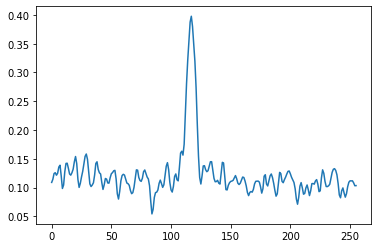

In [7]:
# show spectra quicklook + normalize
#spectra_orig = data['spectra'].values.copy()
spectra_orig = gaussian_filter1d(data['spectra'].values.copy(), sigma=1)

print(spectra_orig.min(), spectra_orig.max())

# normalize between 0 and 1
spectra_norm = (spectra_orig - spectra_orig.min()) / (spectra_orig.max()-spectra_orig.min())
plt.plot(spectra_norm[1000, :])

print(spectra_norm.min(), spectra_norm.max())

In [8]:
X = np.zeros((spectra_norm.shape)+(6,))
for i in range(spectra_norm.shape[0]):
    for j in range(6):
        X[i, :, j] = spectra_norm[i, :]

In [9]:
prediction = VoodooPredictor(X)

Loading Vnet model ...... VnetSettings-1.toml


In [34]:
prediction_smoothed = np.zeros((nonzeros_mask.shape)+(3,))
for i in range(NCLASSES):
    _tmp = reshape(prediction[:, i], ~nonzeros_mask)
    _tmp = gaussian_filter(_tmp, sigma=1)
    prediction_smoothed[:, :, i] = np.ma.masked_where(~nonzeros_mask, _tmp)
    
fake_Z = reshape3d(data['spectra'].values, ~nonzeros_mask)
fake_Z = np.ma.masked_where(~nonzeros_mask, np.sum(10**(fake_Z/10), axis=2)).T
fake_Z = 10*np.log10(fake_Z)
print(fake_Z.min(), fake_Z.max())

-70.22046193554945 -47.41140599421274


(976, 582, 256)

Text(0.5, 1.0, 'Voodoo output - probabiltiy for cloud droplets')

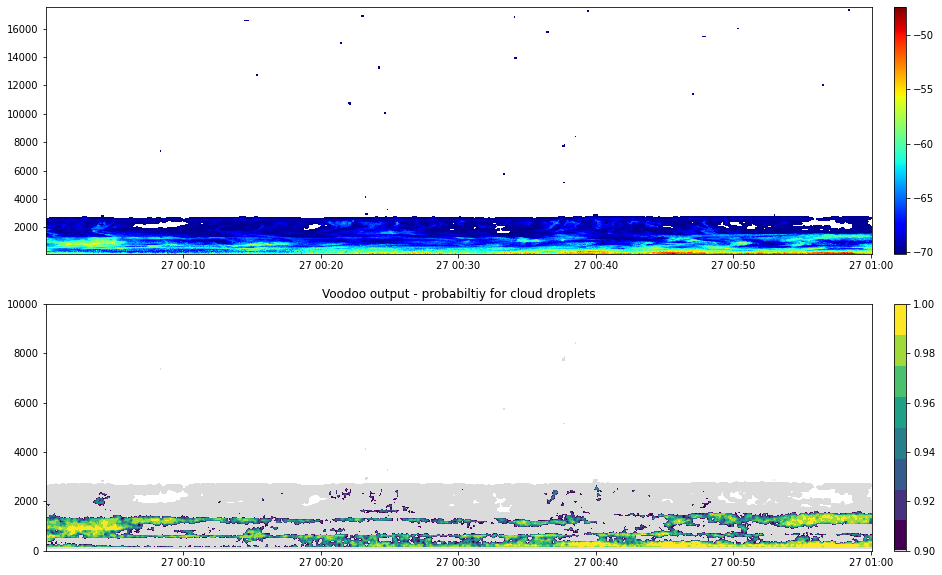

In [38]:

# VOODOO cloud droplet likelyhood colorbar (viridis + grey below minimum value)
from matplotlib import cm
from matplotlib.colors import ListedColormap
viridis = cm.get_cmap('viridis', 8)
newcolors = viridis(np.linspace(0, 1, 256))
newcolors[:1, :] = np.array([220/256, 220/256, 220/256, 1])


fig, ax = plt.subplots(nrows=2, figsize=(16, 10))

pcmesh = ax[0].pcolormesh(
    data['time_offset'].values,
    data['range'].values,    
    fake_Z,
    cmap='jet',
    vmin=fake_Z.min(), vmax=fake_Z.max(),
)
cbar = fig.colorbar(pcmesh, ax=ax[0], fraction=0.05, pad=0.025)    
ax[1].set_ylim([0, 10000])
ax[1].set_title('fake_Z (sum of power spectra)')


pcmesh = ax[1].pcolormesh(
    data['time_offset'].values,
    data['range'].values,    
    np.ma.masked_where(~nonzeros_mask, prediction_smoothed[:, :, 1]).T, 
    cmap=ListedColormap(newcolors), 
    vmin=0.9, vmax=1
)
cbar = fig.colorbar(pcmesh, ax=ax[1], fraction=0.05, pad=0.025)    
ax[1].set_ylim([0, 10000])
ax[1].set_title('Voodoo output - probabiltiy for cloud droplets')